### In QA V5, I check whether the length of T actually plays a role, or is it the same as adjusting alpha.

Here in QA V5.1, I only vary T from 1 to 10000, incrementing by 10x over 5 loops.

# Conclusion

Between QA V5.1 and QA V5.2, the results turn out to be pretty much identical


Conclusion 1: from now on we can safely just set T_max to 1, and we only need to vary alpha, because increasing T_max and increasing alpha gives the same results. Why vary alpha instead of T_max? Because larger T_max makes the code longer to run, because now you have more time steps to iterate through, which means more matrix multiplications.


Conclusion 2: it seems that the accuracy-alpha graph is almost monotonically increasing. Which means if we want to increase the accuracy, we just need to increase alpha?

In [12]:
import numpy as np
from scipy.linalg import expm
import scipy
import matplotlib.pyplot as plt
import time

In [13]:
np.set_printoptions(suppress=True)
np.set_printoptions(precision=3)

In [14]:
sigmaI = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
sigmaX = np.array(
    [
        [0, 1],
        [1, 0],
    ]
)
sigmaBin = np.array(
    [
        [0, 0],
        [0, 1],
    ]
)

In [15]:
Values = [10, 5]
Weights = [2, 3]
Ancil = [1, 2]

alpha = 1
beta = 1
gamma = max(Values) + 1
T = 1
dt = 0.01
t_axis = np.arange(0, T, dt)[0:]

In [16]:
H0 = np.array([
[ 0.,7.14,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 7.14,0.,10.097,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,10.097,0.,12.367,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,12.367,0.,14.28,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,14.28,0.,15.966,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,15.966,0.,17.489,0.,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,17.489,0.,18.891,0.,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,18.891,0.,20.195,0.,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,20.195,0.,21.42,0.,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,21.42,0.,22.579,0.,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,22.579,0.,23.681,0.,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,23.681,0.,24.734,0.,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,24.734,0.,25.744,0.,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,25.744,0.,26.715,0.,],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,26.715,0.,27.653],
[ 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,27.653,0.,]
])
# print(H0)

eigenvals_H0, eigenvecs_H0 = np.linalg.eigh(H0)
ground_idx_H0 = eigenvals_H0.argsort()[0]
print(eigenvals_H0[ground_idx_H0])
print(eigenvecs_H0[:, ground_idx_H0])

-47.34465334125993
[-0.     0.    -0.     0.001 -0.004  0.011 -0.026  0.056 -0.106  0.182
 -0.281  0.389 -0.475  0.5   -0.428  0.25 ]


In [17]:
Hp = (
    - (Values[0] * np.kron(np.kron(np.kron(sigmaBin, sigmaI), sigmaI), sigmaI) + Values[1] * np.kron(np.kron(np.kron(sigmaI, sigmaBin), sigmaI), sigmaI))
    + gamma * (
        (Weights[0] * np.kron(np.kron(np.kron(sigmaBin, sigmaI), sigmaI), sigmaI) + Weights[1] * np.kron(np.kron(np.kron(sigmaI, sigmaBin), sigmaI), sigmaI))
      - (Ancil[0] * np.kron(np.kron(np.kron(sigmaI, sigmaI), sigmaBin), sigmaI) + Ancil[1] * np.kron(np.kron(np.kron(sigmaI, sigmaI), sigmaI), sigmaBin))
    )**2
)
# print(Hp)

eigenvals_Hp, eigenvecs_Hp = np.linalg.eigh(Hp)
ground_idx_Hp = eigenvals_Hp.argsort()[0]
print(eigenvals_Hp[ground_idx_Hp])
print(eigenvecs_Hp[:, ground_idx_Hp])


-10.0
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [18]:
def H(t, T=1, alpha=1, beta=1):
    return alpha * ( (1 - t/T)*beta*H0 + (t/T)*Hp )

In [20]:
psi_ini = eigenvecs_H0[:, ground_idx_H0]
# print(psi_ini)
# print(np.linalg.norm(psi_ini))

psi_correct = eigenvecs_Hp[:, ground_idx_Hp]
# print(psi_correct)

In [21]:
T_list = np.arange(1e-1, 1e1, 1e-1)
accuracy_list = []

for T in T_list:
    start_time = time.time()

    t_axis = np.arange(0, T, dt)

    junrui_unitary = np.identity(len(H0))
    for t in t_axis:
        junrui_unitary = expm(-1j * H(t, T=T) * dt) @ junrui_unitary

    psi_final = junrui_unitary @ psi_ini

    accuracy = np.abs( np.dot(psi_correct, psi_final) )**2
    accuracy_list.append(accuracy)

    end_time = time.time()
    # print(f"T = {T}, loop time: {end_time - start_time}")

In [22]:
print(accuracy_list)

[np.float64(0.05443297751951052), np.float64(0.2332360464178557), np.float64(0.4263127949867593), np.float64(0.3626417637414392), np.float64(0.2226408170901909), np.float64(0.17088776798972272), np.float64(0.21634195746210777), np.float64(0.30654704521858495), np.float64(0.38377064008991385), np.float64(0.3887444538086738), np.float64(0.3377751462824244), np.float64(0.34744572967688236), np.float64(0.4273373214028768), np.float64(0.5254783030175596), np.float64(0.5545665511953076), np.float64(0.512488705390446), np.float64(0.45822684074248027), np.float64(0.45340341927894057), np.float64(0.5088957835640816), np.float64(0.585862156816825), np.float64(0.6369158748527532), np.float64(0.6366258184876578), np.float64(0.6073222781081216), np.float64(0.5838346102734542), np.float64(0.5932335975071464), np.float64(0.6227771041291722), np.float64(0.6504452095394522), np.float64(0.6690836757420348), np.float64(0.6883179411688257), np.float64(0.705975043307143), np.float64(0.7133369376755252), np

0.9863078697176073


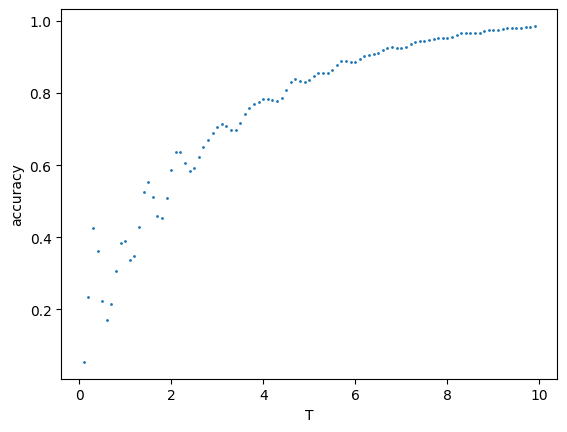

In [27]:
plt.scatter(T_list, accuracy_list, s=1)
plt.xlabel("T")
plt.ylabel("accuracy")
print(max(accuracy_list))

In [23]:
# T = 0.1
# accuracy_list = []

# for i in range(5):
#     start_time = time.time()

#     T = T * 10
#     t_axis = np.arange(0, T, dt)

#     junrui_unitary = np.identity(len(H0))
#     for t in t_axis:
#         junrui_unitary = expm(-1j * H(t, T=T) * dt) @ junrui_unitary

#     psi_final = junrui_unitary @ psi_ini

#     accuracy = np.abs( np.dot(psi_correct, psi_final) )**2
#     accuracy_list.append(accuracy)

#     end_time = time.time()
#     print(f"T = {T}, loop time: {end_time - start_time}")



In [24]:
# print(accuracy_list)
# [np.float64(0.3887444538086738), np.float64(0.986489936436699), np.float64(0.9999638539903875), np.float64(0.9999996393900755), np.float64(0.9999999963881061)]